<a href="https://colab.research.google.com/github/prtlobo/Coursera_Capstone/blob/master/MTR_Clustering_based_on_Foursquare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IBM Data Science Capstone Project

## Clustering Hong Kong MTR Stations

#### By Rafael Lobo

---

## Gathering MTR Station Coordinates and Routes

In [ ]:
import numpy as np 
import pandas as pd
!pip install geopandas
import geopandas as gpd
import requests
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
! pip install folium==0.6.0
import folium
import folium.plugins as plugins
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
#Used Overpass Turbo to output a Geojson file and then saved it on my Github repo
#This file is for generating the MTR routes
github='https://raw.githubusercontent.com/prtlobo/Coursera_Capstone/master/MTR.geojson'
#Then used Geopandas to read the geojson file
mtrroutegeo=gpd.read_file(github)
#This file is for the stations
github2='https://raw.githubusercontent.com/prtlobo/Coursera_Capstone/master/MTR%20stops.geojson'
mtrstationgeo=gpd.read_file(github2)
#filter just the routes and not the stops
routes=mtrroutegeo[mtrroutegeo['id'].str.contains('relation')]
#remove monorail, light rail, ocean park stops, and unofficially opened stations
mtrstationgeo=mtrstationgeo[mtrstationgeo['monorail'] != 'yes']
mtrstationgeo=mtrstationgeo[mtrstationgeo['light_rail'] != 'yes']
mtrstationgeo=mtrstationgeo[mtrstationgeo['name:en'] != 'Summit']
mtrstationgeo=mtrstationgeo[mtrstationgeo['name:en'] != 'Waterfront']
mtrstationgeo=mtrstationgeo[mtrstationgeo['note'] != 'station to be added at opening']
mtrstationgeo=mtrstationgeo.drop_duplicates('name:en').reset_index(drop=True)
#Create new normal dataframe from geodataframe
mtrstationgeo['Latitude']=mtrstationgeo['geometry'].y
mtrstationgeo['Longitude']=mtrstationgeo['geometry'].x
stations=pd.DataFrame(mtrstationgeo[['name:en','Latitude','Longitude']].copy())
stations=stations.rename(columns={'name:en':'Station'})
stations.head(1)

,Station,Latitude,Longitude
0,Tsing Yi,22.358341,114.107421


In [48]:
#Extract table(s) from wikipedia
wiki='https://en.wikipedia.org/wiki/List_of_MTR_stations'
site=requests.get(wiki).text
wikiscrape=pd.read_html(site,flavor='bs4')
linecolors=['#53B7E8','#00AB4E','#ED1D24','#007DC5','#F7943E','#00888A','#7D499D','#A3238F','#923011','#F173AC','#BAC429']
lines=['East Rail line','Kwun Tong line','Tsuen Wan line','Island line','Tung Chung line','Airport Express','Tseung Kwan O line','West Rail line','Tuen Ma line Phase 1','Disneyland Resort line','South Island line']

#Add MTR line name and color before concat
for i in range(0,11):
    temp_df=wikiscrape[i]
    temp_df.insert(2,'Line', lines[i])
    temp_df.insert(7, 'Line Color', linecolors[i])
#Cleaning up some stations names
mtr=pd.concat(wikiscrape[0:11])
mtr.drop(['Livery','Code','Photo','Connections','Opened','Notes','District'], axis=1,inplace=True)
mtr.reset_index(drop=True,inplace=True)
mtr.iloc[6,0]='University'
mtr.iloc[12,0]='Mong Kok East'
mtr.iloc[13,0]='Hung Hom'
mtr.iloc[16,0]='Yau Ma Tei'
mtr.iloc[17,0]='Mong Kok'
mtr.iloc[36,0]='Mei Foo'
mtr.iloc[41,0]='Mong Kok'
mtr.iloc[42,0]='Yau Ma Tei'
mtr.iloc[46,0]='Central'
mtr.iloc[72,0]='AsiaWorld-Expo'
mtr=mtr.rename(columns={'Name':'Station'})
mtr.drop_duplicates('Station',inplace=True)
mtr.reset_index(drop=True)
mtr.head()

,Station,Line,Line Color
0,Lo Wu,East Rail line,#53B7E8
1,Lok Ma Chau,East Rail line,#53B7E8
2,Sheung Shui,East Rail line,#53B7E8
3,Fanling,East Rail line,#53B7E8
4,Tai Wo,East Rail line,#53B7E8


In [4]:
#Merge the Wiki table and coordinates from geopandas
mtr_merged=pd.merge(mtr, stations, on='Station', how='left')
mtr_merged.loc[mtr_merged['Station']=='South Horizons',['Latitude','Longitude']]=[22.2425,114.1491]
mtr_merged.head()

,Station,Line,Line Color,Latitude,Longitude
0,Lo Wu,East Rail line,#53B7E8,22.528200,114.113140
1,Lok Ma Chau,East Rail line,#53B7E8,22.514448,114.065791
2,Sheung Shui,East Rail line,#53B7E8,22.501124,114.128050
3,Fanling,East Rail line,#53B7E8,22.492042,114.138666
4,Tai Wo,East Rail line,#53B7E8,22.450966,114.161201


## Map of MTR stations and Routes

Have Checkboxes to select MTR routes, Stations, and stations with the search area to be passed to Foursquare

In [66]:
#plot Geojson Routes, Stations and Foursquare API radius
map_hk = folium.Map(tiles=None, location=[22.3193,114.1694])

folium.TileLayer('Cartodb dark_matter', overlay=False, control=False).add_to(map_hk)

#Plot MTR Routes
routefeaturegroup=folium.FeatureGroup('MTR Routes', show=True)
for i in range(0,len(routes)):
  geom=routes.iloc[[i]]
  color=routes.loc[i,'colour']
  gjson = folium.features.GeoJson(geom, style_function= lambda feature, color=color: {'color':color, 'weight':1})                                                                     
  routefeaturegroup.add_child(gjson)
#Plot Stations
stationfeaturegroup=folium.FeatureGroup('MTR stations', show=True)
for lat, lng, station, clr in zip(mtr_merged['Latitude'],mtr_merged['Longitude'], mtr_merged['Station'], mtr_merged['Line Color']):
    label = '{} Station'.format(station)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        tooltip=label,
        color=clr,
        fill=True,
        fill_color=clr,
        fill_opacity=1,
        ).add_to(stationfeaturegroup)

#plot stations with API radius
foursquarefeaturegroup=folium.FeatureGroup(name='FourSquare API Radius',show=False)
for lat, lng, clr in zip(mtr_merged['Latitude'],mtr_merged['Longitude'], mtr_merged['Line Color']):
  folium.Circle(
    radius=500,
    location=[lat, lng],
    color=clr,
    fill=True,
    fill_color=clr,
    fill_opacity=0.4).add_to(foursquarefeaturegroup)

routefeaturegroup.add_to(map_hk)
stationfeaturegroup.add_to(map_hk)
foursquarefeaturegroup.add_to(map_hk)
#map_hk.add_child(folium.LayerControl())
folium.LayerControl(collapsed=False).add_to(map_hk)
folium.FitBounds(stationfeaturegroup.get_bounds()).add_to(map_hk)
map_hk

## Foursquare API

In [27]:
#Setting Foursquare API information
CLIENT_ID = '1Y1POAQZYKKWV5S4GZ4ZIMWLHACQ5RQM4AKRUED4CA4CYII4'
CLIENT_SECRET = 'LO3AZXWDBGTSRRGGUCHNQSSJK45QDXDHWJZGL1TB15DN13ME'
ACCESS_TOKEN = 'JKCYRFUYKF3XCWKPIA2RXTLZEY351MPZW3HE3UDDPLN0WIAO'
VERSION = '20180605'
LIMIT = 100
radius = 500

#function to get venues for each  postal code
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Station', 
                  'Station Latitude', 
                  'Station Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [55]:
mtr_venues = getNearbyVenues(names=mtr_merged['Station'],
                                   latitudes=mtr_merged['Latitude'],
                                   longitudes=mtr_merged['Longitude']
                                  )
mtr_venues.head()

,Station,Station Latitude,Station Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Lo Wu,22.5282,114.11314,星巴克,22.529067,114.113027,Coffee Shop
1,Lo Wu,22.5282,114.11314,KFC (肯德基),22.532081,114.113630,Fast Food Restaurant
2,Lo Wu,22.5282,114.11314,Lo Wu Control Point (羅湖出入境管制站),22.529425,114.113456,Border Crossing
3,Lo Wu,22.5282,114.11314,MTR Lo Wu Station Platform 1 (港鐵羅湖站1號月台),22.527801,114.113192,Platform
4,Lo Wu,22.5282,114.11314,Hong Kong Delight,22.529049,114.113241,Chinese Restaurant


In [56]:
#check if Foursquare returned any missing/empty results
mtr_merged['Missing']=mtr_merged['Station'].isin(mtr_venues['Station'])
len(mtr_merged[mtr_merged['Missing']==False])

0

In [57]:
#create one hot for each of the venue catagories then create new dataframe with normalised values
mtr_onehot=pd.get_dummies(mtr_venues[['Venue Category']], prefix="", prefix_sep="")
mtr_onehot.insert(0,'Station', mtr_venues['Station'])
mtr_grouped = mtr_onehot.groupby('Station').mean().reset_index()
mtr_grouped.head()

,Station,ATM,Accessories Store,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,American Restaurant,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Astrologer,Athletics & Sports,Australian Restaurant,BBQ Joint,Bakery,Bar,Beer Bar,Beer Garden,Beer Store,Beijing Restaurant,Belgian Restaurant,Betting Shop,Bistro,Boat or Ferry,Bookstore,Border Crossing,Botanical Garden,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,...,Supermarket,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Takoyaki Place,Tapas Restaurant,Taxi Stand,Tea Room,Temple,Tennis Court,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Tibetan Restaurant,Toll Booth,Toy / Game Store,Track Stadium,Trail,Train Station,Tram Station,Travel Lounge,Tunnel,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Xinjiang Restaurant,Yoga Studio,Yunnan Restaurant,Zhejiang Restaurant,Zoo,Zoo Exhibit
0,Admiralty,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.025316,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.025316,0.0,0.012658,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.012658,0.012658,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.025316,0.0,0.012658,0.012658,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.012658,0.025316,0.0,0.0,0.012658,0.0,0.0,0.0,0.025316,0.000000,0.0,0.012658,0.0
1,Airport,0.0,0.0,0.0,0.022222,0.022222,0.022222,0.2,0.0,0.022222,0.0,0.0,0.0,0.0,0.022222,0.0,0.0,0.00000,0.0,0.0,0.066667,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.022222,0.0,0.0,0.0,0.000000,0.022222,0.0,0.000000,0.0
2,AsiaWorld-Expo,0.0,0.0,0.0,0.034483,0.000000,0.034483,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.000000,0.034483,0.0,0.0,0.0,0.0,0.0,0.0,0.034483,0.034483,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.034483,0.0,0.0,0.00000,0.0,0.034483,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0
3,Austin,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.02439,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.024390,0.0,0.000000,0.000000,0.02439,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.02439,0.0,0.000000,0.0,0.0,0.000000,0.024390,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0
4,Causeway Bay,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.023810,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.023810,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.011905,...,0.023810,0.035714,0.0,0.011905,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.011905,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.011905,0.0,0.0,0.000000,0.0,0.0,0.0,0.011905,0.000000,0.0,0.000000,0.0


In [58]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Station']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

mtr_venues_sorted = pd.DataFrame(columns=columns)
mtr_venues_sorted['Station'] = mtr_grouped['Station']

for ind in np.arange(mtr_grouped.shape[0]):
    mtr_venues_sorted.iloc[ind, 1:] = return_most_common_venues(mtr_grouped.iloc[ind, :], num_top_venues)

mtr_venues_sorted.head()

,Station,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Admiralty,Café,Hotel,Italian Restaurant,Steakhouse,Clothing Store,Burger Joint,Park,Bakery,Coffee Shop,Bookstore
1,Airport,Airport Lounge,Coffee Shop,Bakery,Japanese Restaurant,Gift Shop,Candy Store,Dumpling Restaurant,Chocolate Shop,Pizza Place,Furniture / Home Store
2,AsiaWorld-Expo,Coffee Shop,Café,Travel Lounge,Gym,Boat or Ferry,Bistro,Convenience Store,Convention Center,Middle Eastern Restaurant,Bar
3,Austin,Chinese Restaurant,Dessert Shop,Coffee Shop,Café,Hotpot Restaurant,Seafood Restaurant,Cha Chaan Teng,Noodle House,Indian Restaurant,Tea Room
4,Causeway Bay,Japanese Restaurant,Hotel,Noodle House,Coffee Shop,Clothing Store,Dessert Shop,Cha Chaan Teng,Sushi Restaurant,Seafood Restaurant,Hong Kong Restaurant


## Optimize and Create Kmeans clustering models

In [59]:
#finding best k number for cluster using silououette score
mtr_grouped_clustering = mtr_grouped.drop('Station', 1)

sil = []
kmax = 20

for k in range(2, kmax+1):
  kmeanstest = KMeans(n_clusters=k, random_state=0).fit(mtr_grouped_clustering)
  labels = kmeanstest.labels_
  sil.append(silhouette_score(mtr_grouped_clustering, labels, metric = 'euclidean'))

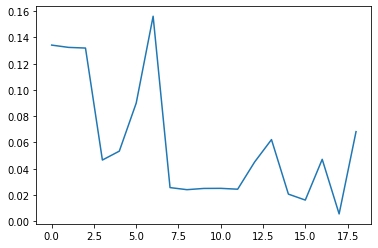

In [60]:
plt.plot(sil)
plt.show()

### Will try 2 models: 


*   Using best k according to silhouette Score
*   Using the same number of existing MTR lines



In [61]:
#choose k with highest silhouhette score after k=1
kbest=sil.index(max(sil[2:20]))
kmeanbest = KMeans(n_clusters=kbest, random_state=0).fit(mtr_grouped_clustering)
#choose k by number of MTR lines
klines=len(lines)
kmeanlines = KMeans(n_clusters=klines, random_state=0).fit(mtr_grouped_clustering)

print('The best K for clustering is: {}'.format(kbest))
print('The number of MTR lines is: {}'.format(klines))

The best K for clustering is: 6
The number of MTR lines is: 11


In [62]:
#Combine cluster label results with postcode data and Foursquare API data excluding missing post codes
mtr_venues_kmean=mtr_venues_sorted
#postal_venues_kmean.drop('Cluster Labels',1, inplace=True)
mtr_venues_kmean.insert(0, 'Cluster Labels (kbest)', kmeanbest.labels_)
mtr_venues_kmean.insert(1, 'Cluster Labels (klines)', kmeanlines.labels_)
mtr_results=mtr_merged
mtr_results.drop('Missing', axis=1, inplace=True)
mtr_results = mtr_results.join(mtr_venues_kmean.set_index('Station'), on='Station')
mtr_results.head()

,Station,Line,Line Color,Latitude,Longitude,Cluster Labels (kbest),Cluster Labels (klines),1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Lo Wu,East Rail line,#53B7E8,22.528200,114.113140,1,0,Platform,Fast Food Restaurant,Border Crossing,Bakery,Chinese Restaurant,Convenience Store,Metro Station,Coffee Shop,Noodle House,Bus Station
1,Lok Ma Chau,East Rail line,#53B7E8,22.514448,114.065791,1,0,Platform,Train Station,Bus Station,Border Crossing,Taxi Stand,Convenience Store,Spa,Zoo Exhibit,Frozen Yogurt Shop,Food Court
2,Sheung Shui,East Rail line,#53B7E8,22.501124,114.128050,2,5,Fast Food Restaurant,Restaurant,Seafood Restaurant,Food Court,Athletics & Sports,Chinese Restaurant,Convenience Store,Cha Chaan Teng,Coffee Shop,Bus Station
3,Fanling,East Rail line,#53B7E8,22.492042,114.138666,2,5,Fast Food Restaurant,Cha Chaan Teng,Platform,Sushi Restaurant,Convenience Store,Bus Station,Donburi Restaurant,Noodle House,Chinese Restaurant,Multiplex
4,Tai Wo,East Rail line,#53B7E8,22.450966,114.161201,3,8,Japanese Restaurant,Coffee Shop,Wine Bar,Snack Place,Fast Food Restaurant,Train Station,Cantonese Restaurant,Noodle House,History Museum,Gas Station


## Map of Clusters

Ability to toggle between K best and K based on MTR lines (11)

In [65]:
#plot map with toggle between K best and K lines
map_clusters = folium.Map(tiles=None, location=[22.3193,114.1694])

folium.TileLayer('Cartodb dark_matter', overlay=False, control=False).add_to(map_clusters)

#Plot cluster points for K best
clusterkbest=folium.FeatureGroup('K Best Cluster', overlay=False)
for lat, lng, stn, cluster in zip(mtr_results['Latitude'], mtr_results['Longitude'], mtr_results['Station'], mtr_results['Cluster Labels (kbest)']):
    label = str(stn) + ' Cluster ' + str(cluster)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        tooltip=label,
        color=linecolors[cluster],
        fill=True,
        fill_color=linecolors[cluster],
        fill_opacity=1).add_to(clusterkbest)    
#Plot cluster points for K lines
clusterkline=folium.FeatureGroup('MTR Line Cluster', overlay=False)
for lat, lng, stn, cluster in zip(mtr_results['Latitude'], mtr_results['Longitude'], mtr_results['Station'], mtr_results['Cluster Labels (klines)']):
    label = str(stn) + ' Cluster ' + str(cluster)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        tooltip=label,
        color=linecolors[cluster],
        fill=True,
        fill_color=linecolors[cluster],
        fill_opacity=1).add_to(clusterkline)
clusterkbest.add_to(map_clusters)
clusterkline.add_to(map_clusters)
folium.LayerControl(collapsed=False).add_to(map_clusters)
folium.FitBounds(clusterkbest.get_bounds()).add_to(map_clusters)
map_clusters


## Thank for your time in reading this project!